# Simulating flow

To use `bluebonnet.flow` in a project:

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import bluebonnet as bb
from bluebonnet.flow import IdealReservoir, FlowProperties, SinglePhaseReservoir,RelPermParams
from bluebonnet.fluids.fluid import Fluid, pseudopressure
from bluebonnet.plotting import SquareRootScale

plt.style.use("ggplot")

In [2]:
def plot_pseudopressure(reservoir, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = np.linspace(0, 1, reservoir.nx)
    for i, p in enumerate(reservoir.pseudopressure):
        if i % 200 == 0:
            ax.plot(x,p, color='steelblue')
    ax.set(xlabel="x", ylabel="Pseudopressure", xlim=(0, 1), ylim=(0,1.05))
    return fig, ax

def plot_recovery_factor(reservoir, ax=None, change_ticks=False):
    if ax is None:
        fig, ax = plt.subplots()
    rf = reservoir.recovery_factor()
    time = reservoir.time
    ax.plot(time, rf)
    ax.set(xscale='squareroot', ylim=(0, None), xlim=(0, max(time)))
    if change_ticks:
        tick_locs = np.round((np.linspace(0,1,7) * np.sqrt(max(time)))**2,1)
        ax.set_xticks(tick_locs)
    return ax


## Ideal gas simulation

In [3]:
t_end = 6
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2

res_ideal = IdealReservoir(50, 1000, 9000, None)
%time res_ideal.simulate(time)
rf_ideal = res_ideal.recovery_factor()

CPU times: user 4.7 s, sys: 77.3 ms, total: 4.78 s
Wall time: 4.88 s


[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Recovery factor')]

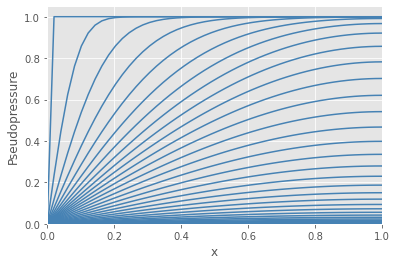

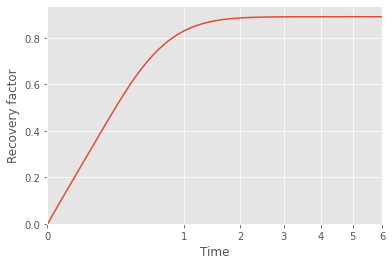

In [4]:
ax = plot_pseudopressure(res_ideal)

ax = plot_recovery_factor(res_ideal)
ax.set(xlabel="Time", ylabel="Recovery factor")

## Real gas simulation

<AxesSubplot:xlabel='pseudopressure', ylabel='diffusivity'>

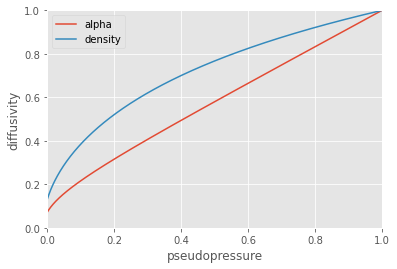

In [5]:
pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv")

def scale_pressure_diffusivity(df):
    out = df.assign(
        alpha=lambda x: 1/(x.Cg * x.Viscosity), 
        density=lambda x: x.Density/max(x.Density),
        pseudopressure=lambda x: (x["pseudopressure"] - x["pseudopressure"].min()) / 
            (x["pseudopressure"].max() - x["pseudopressure"].min()),
    ).assign(
        alpha=lambda x: x.alpha/x.alpha.iloc[-1]
    )[["pseudopressure", "alpha", "density"]]
    return out

fluid_properties = (
    pvt_gas[pvt_gas.P>=1000]
    .pipe(scale_pressure_diffusivity)
)
ax = fluid_properties.plot(x='pseudopressure', y="alpha")
ax.set(ylim=(0,1), xlim=(0,1), ylabel="diffusivity")
fluid_properties.plot(x="pseudopressure", y="density", ax=ax)

In [6]:
flow_properties = FlowProperties(fluid_properties, fvf_scale=0.3579)

res_realgas = SinglePhaseReservoir(50, 1000, 12000, flow_properties)

%time res_realgas.simulate(time)
rf2 = res_realgas.recovery_factor()

CPU times: user 5.49 s, sys: 27.7 ms, total: 5.51 s
Wall time: 5.52 s


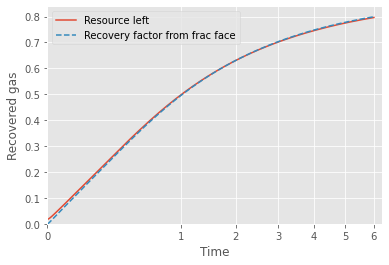

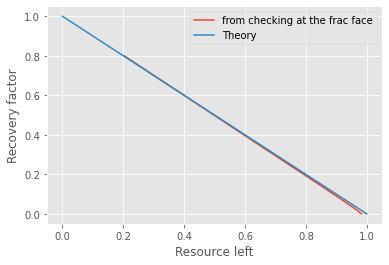

In [7]:
from scipy import interpolate
density_interp = interpolate.interp1d(fluid_properties["pseudopressure"], fluid_properties["density"])
def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt["pseudopressure"], pvt["density"])
    return (density(pseudopressure)).sum(axis=1)
remaining_gas = resource_left(res_realgas.pseudopressure, fluid_properties) / res_realgas.nx
fig, ax = plt.subplots()
ax.plot(time, 1 - remaining_gas, label="Resource left")
ax.plot(time, rf2,"--", label="Recovery factor from frac face")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

fig, ax = plt.subplots()
ax.plot(remaining_gas, rf2 , label="from checking at the frac face")
ax.plot([1,0], [0,1], label="Theory")
ax.set(xlabel="Resource left", ylabel="Recovery factor")
ax.legend()

[Text(0.5, 0, 'Time'),
 Text(0, 0.5, 'Recovery factor'),
 (0.0, 0.9352331895079818),
 None,
 (0.0, 6.299999999999999)]

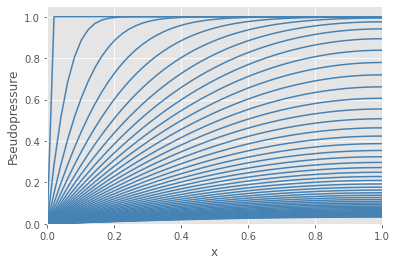

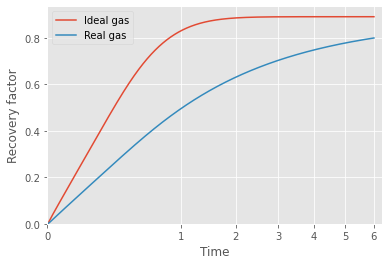

In [8]:
ax = plot_pseudopressure(res_realgas)

fig, ax = plt.subplots()
ax.plot(time, rf_ideal, label="Ideal gas")
ax.plot(time, rf2, label="Real gas")
ax.legend()
ax.set(xlabel="Time", ylabel="Recovery factor", ylim=(0,None), xscale='squareroot', xlim=(0,None))

## Multiphase flow

In [9]:
rel_perm_params = RelPermParams(n_o=2, n_g=2, n_w=2, S_or=0.2, S_wc=0.1, S_gc=0, k_ro_max=0.8, k_rw_max=0, k_rg_max=1)

In [10]:
initial_saturations = {"So": 0.5, "Sg": 0.2, "Sw": 0.3}
sum(v for v in initial_saturations.values())

1.0